In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Load data
sample_info = pd.read_csv('data/brain_sample_descriptions_PFC.csv')
gene_data = pd.read_csv('data/braindat.csv', index_col=0).T

# Merge datasets on common identifier
data = sample_info.merge(gene_data, left_on='!Sample_geo_accession', right_index=True, how='inner')
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['Disease'] = data['Disease'].map({'A': 1, 'N': 0})

# Extract features and target variable
X = data.drop(columns=['Disease', '!Sample_title', '!Sample_geo_accession'])
X.columns = X.columns.astype(str)  # Ensure all feature names are strings
y = data['Disease'] 

# Gradient Boosting Classifier
boosted_tree = GradientBoostingClassifier(random_state=42, n_estimators=1)
boosted_tree.fit(X, y)

GradientBoostingClassifier(n_estimators=1, random_state=42)


Top 30 Features by Importance:
            Feature    Importance
36775  10025934933  7.266526e-01
20939  10025909808  1.038068e-01
9965   10023831601  6.720259e-02
22026  10025910913  5.344320e-02
22245  10025911139  3.044983e-02
16096  10025904885  1.844500e-02
26550  10025917016  1.291205e-16
26184  10025916388  0.000000e+00
26185  10025916389  0.000000e+00
26186  10025916391  0.000000e+00
26187  10025916392  0.000000e+00
26188  10025916393  0.000000e+00
26189  10025916396  0.000000e+00
26190  10025916399  0.000000e+00
26191  10025916404  0.000000e+00
26183  10025916387  0.000000e+00
26193  10025916406  0.000000e+00
26194  10025916411  0.000000e+00
26195  10025916412  0.000000e+00
26196  10025916414  0.000000e+00
26197  10025916415  0.000000e+00
26198  10025916416  0.000000e+00
26199  10025916417  0.000000e+00
26192  10025916405  0.000000e+00
26166  10025916360  0.000000e+00
26167  10025916361  0.000000e+00
26168  10025916363  0.000000e+00
26169  10025916366  0.000000e+00
26170  100

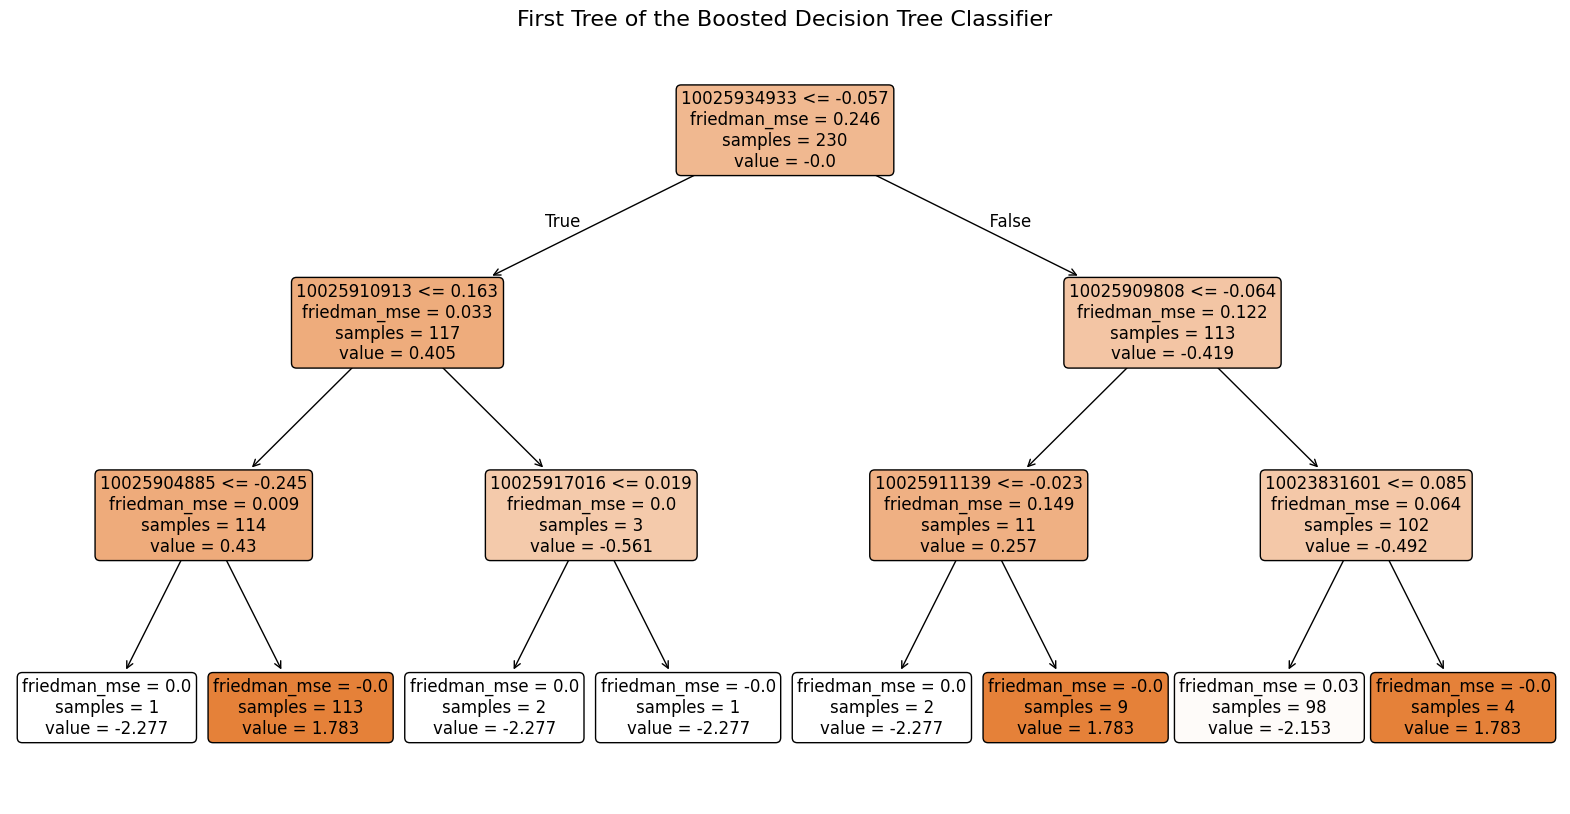

In [2]:
# Get and print feature importances
feature_importances = boosted_tree.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance and get the top 30
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(30)
print("\nTop 30 Features by Importance:\n", top_features)

# Plot the first tree of the Gradient Boosting Classifier
plt.figure(figsize=(20, 10))
plot_tree(boosted_tree.estimators_[0, 0], 
          filled=True, 
          feature_names=X.columns, 
          class_names=['N', 'A'], 
          rounded=True, 
          fontsize=12,
          label='all')
plt.title('First Tree of the Boosted Decision Tree Classifier', fontsize=16)
plt.show()

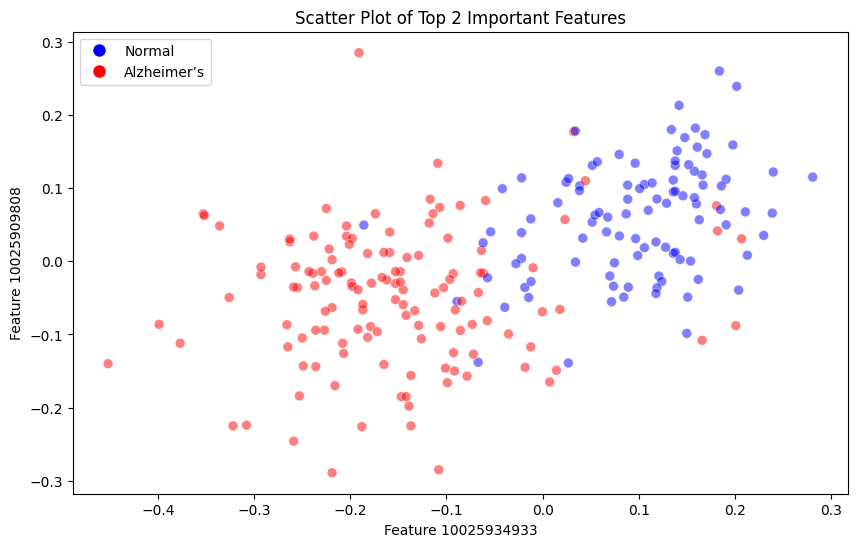

In [3]:
import seaborn as sns

top_features = ['10025934933', '10025909808']

cols = ["Alzheimer's" if i == 1 else "Normal" for i in y]

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[top_features[0]], y=X[top_features[1]], c=pd.Series(cols).map({"Alzheimer's": 'red', "Normal": 'blue'}), s=50, alpha=0.5)
plt.xlabel(f'Feature {top_features[0]}')
plt.ylabel(f'Feature {top_features[1]}')
plt.title('Scatter Plot of Top 2 Important Features')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Normal', markersize=10, markerfacecolor='blue'),
                    plt.Line2D([0], [0], marker='o', color='w', label='Alzheimer’s', markersize=10, markerfacecolor='red')])
plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Load data
sample_info = pd.read_csv('data/brain_sample_descriptions_PFC.csv')
gene_data = pd.read_csv('data/braindat.csv', index_col=0).T

# Merge datasets on common identifier
data = sample_info.merge(gene_data, left_on='!Sample_geo_accession', right_index=True, how='inner')
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['Disease'] = data['Disease'].map({'A': 1, 'N': 0})

# Extract features and target variable
X = data.drop(columns=['Disease', '!Sample_title', '!Sample_geo_accession', 'Age', 'Sex'])
X.columns = X.columns.astype(str)  # Ensure all feature names are strings
y = data['Disease']  

# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

num_c_vals = 100

# Define a range of inverse regularization strengths (C values)
C_values = np.logspace(-4, 4, num_c_vals)

# Perform Lasso logistic regression with cross-validation over a range of C values
lasso_cv = LogisticRegressionCV(
    Cs=C_values, cv=5, penalty='l1', solver='liblinear', scoring='neg_log_loss', max_iter=10000
)
lasso_cv.fit(X_scaled, y)

# Optimal lambda is the inverse of the best C found
optimal_lambda = 1 / lasso_cv.C_[0]
print("Optimal λ (lambda):", optimal_lambda)

Optimal λ (lambda): 2.310129700083158


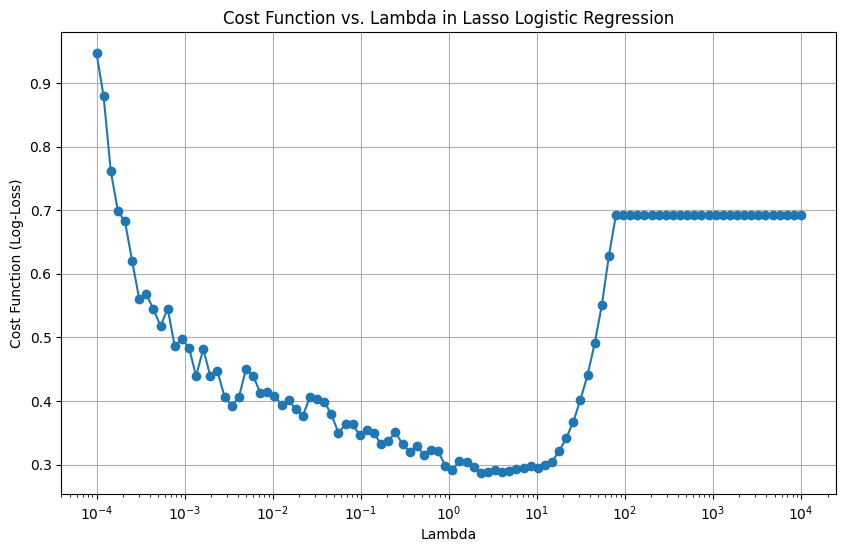

In [6]:
# Extract mean cross-validated scores for each C
mean_cost = -lasso_cv.scores_[1].mean(axis=0)  # Using log-loss scores; convert from negative

# Convert C values to lambda
lambda_values = 1 / lasso_cv.Cs_

# Plot cost function vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, mean_cost, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Cost Function (Log-Loss)')
plt.title('Cost Function vs. Lambda in Lasso Logistic Regression')
plt.grid(True)
plt.show()


In [12]:
# Get the coefficients from the fitted model
coef = lasso_cv.coef_.flatten()

# Create a DataFrame with gene names and their coefficients, sorted by importance
gene_importance = pd.DataFrame({
    'Gene': X.columns,  # Replace with gene names or feature names
    'Coefficient': coef
})
# Filter out genes with a coefficient of zero (not selected by Lasso)
important_genes = gene_importance[gene_importance['Coefficient'] != 0]
# Sort by absolute value of the coefficient in descending order
important_genes = important_genes.reindex(important_genes.Coefficient.abs().sort_values(ascending=False).index)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # or a large number if you want to limit it
pd.set_option('display.max_columns', None)

# Now you can print the important_genes DataFrame without truncation
print("Genes ordered by importance and their coefficients:")
print(important_genes)
print(important_genes.index)

# Optionally, you can reset the options back to default after printing if desired
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


Genes ordered by importance and their coefficients:
              Gene  Coefficient
2091   10023809844     2.227831
3826   10023814349     1.637515
4183   10023815322    -1.570194
21515  10025910394     0.500783
1621   10023808677     0.379824
17712  10025906527     0.275226
18236  10025907055     0.262135
25398  10025915015    -0.225019
34867  10025931577    -0.217835
15479  10025904258     0.171855
36215  10025933948     0.076193
37568  10031919807     0.071720
29929  10025922950     0.066381
2081   10023809830     0.034590
39267  10033669034     0.011433
0              Age     0.008794
Index([ 2091,  3826,  4183, 21515,  1621, 17712, 18236, 25398, 34867, 15479,
       36215, 37568, 29929,  2081, 39267,     0],
      dtype='int64')


In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Load data
sample_info = pd.read_csv('data/brain_sample_descriptions_PFC.csv')
gene_data = pd.read_csv('data/braindat.csv', index_col=0).T

# Merge datasets on common identifier
data = sample_info.merge(gene_data, left_on='!Sample_geo_accession', right_index=True, how='inner')
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['Disease'] = data['Disease'].map({'A': 1, 'N': 0})

# Extract features and target variable
X = data.drop(columns=['Disease', '!Sample_title', '!Sample_geo_accession'])
X.columns = X.columns.astype(str)  # Ensure all feature names are strings
y = data['Disease']

# Use whole data set
X_train, y_train = X, y

lasso_log_reg = LogisticRegressionCV(Cs=[1/3.35160], cv=5, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train, y_train)
y_pred_train_lasso = lasso_log_reg.predict(X_train)
apparent_error_rate_lasso = 1 - accuracy_score(y_train, y_pred_train_lasso)
cv_error_rate_lasso = 1 - cross_val_score(lasso_log_reg, X_train, y_train, cv=5).mean()

boosted_trees = GradientBoostingClassifier(n_estimators=1).fit(X_train, y_train)
y_pred_train_boost = boosted_trees.predict(X_train)
apparent_error_rate_boost = 1 - accuracy_score(y_train, y_pred_train_boost)
cv_error_rate_boost = 1 - cross_val_score(boosted_trees, X_train, y_train, cv=5).mean()

# Print results
print("Lasso Logistic Regression - Apparent Error Rate:", apparent_error_rate_lasso)
print("Lasso Logistic Regression - CV Error Rate:", cv_error_rate_lasso)
print("Boosted Trees - Apparent Error Rate:", apparent_error_rate_boost)
print("Boosted Trees - CV Error Rate:", cv_error_rate_boost)


2
3
4
5
6
Lasso Logistic Regression - Apparent Error Rate: 0.07826086956521738
Lasso Logistic Regression - CV Error Rate: 0.09999999999999998
Boosted Trees - Apparent Error Rate: 0.4391304347826087
Boosted Trees - CV Error Rate: 0.4391304347826088


Lasso Logistic Regression - Apparent Error Rate: 0.06956521739130439
Lasso Logistic Regression - CV Error Rate: 1.256819358250193
Boosted Trees - Apparent Error Rate: 0.0
Boosted Trees - CV Error Rate: 0.17826086956521725

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Load data
sample_info = pd.read_csv('data/brain_sample_descriptions_PFC.csv')
gene_data = pd.read_csv('data/braindat.csv', index_col=0).T

# Merge datasets on common identifier
data = sample_info.merge(gene_data, left_on='!Sample_geo_accession', right_index=True, how='inner')
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['Disease'] = data['Disease'].map({'A': 1, 'N': 0})

# Extract features and target variable
X = data.drop(columns=['Disease', '!Sample_title', '!Sample_geo_accession'])
X.columns = X.columns.astype(str)  # Ensure all feature names are strings
y = data['Disease'] 

# Standardize features for Lasso Logistic Regression
scaler = StandardScaler()
X_scaled = X

# Initialize models
lasso_logistic = LogisticRegressionCV(Cs=[1/3.35160], cv=5, penalty='l1', solver='liblinear', max_iter=10000)
boosted_trees = GradientBoostingClassifier()

# Set up K-Fold CV
kf = StratifiedKFold(n_splits=5)
class_names = np.unique(y)
cv_results = {
    "lasso_logistic": {"overall_error": [], "class_error": {cls: [] for cls in class_names}},
    "boosted_trees": {"overall_error": [], "class_error": {cls: [] for cls in class_names}},
}

# Perform CV for each model
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize features for Lasso
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Lasso Logistic Regression and Boosted Trees
    lasso_logistic.fit(X_train_scaled, y_train)
    boosted_trees.fit(X_train, y_train)

    # Get predictions
    lasso_preds = lasso_logistic.predict(X_test_scaled)
    boosted_preds = boosted_trees.predict(X_test)

    # Calculate overall error rates
    cv_results["lasso_logistic"]["overall_error"].append(1 - accuracy_score(y_test, lasso_preds))
    cv_results["boosted_trees"]["overall_error"].append(1 - accuracy_score(y_test, boosted_preds))

    # Calculate class-specific error rates
    for cls in class_names:
        lasso_class_error = (lasso_preds[y_test == cls] != cls).mean()
        boosted_class_error = (boosted_preds[y_test == cls] != cls).mean()
        cv_results["lasso_logistic"]["class_error"][cls].append(lasso_class_error)
        cv_results["boosted_trees"]["class_error"][cls].append(boosted_class_error)

# Summarize CV results
def summarize_results(cv_results):
    summary = {}
    for model in cv_results:
        summary[model] = {
            "overall_error": np.mean(cv_results[model]["overall_error"]),
            "class_error": {cls: np.mean(errors) for cls, errors in cv_results[model]["class_error"].items()},
        }
    return summary

cv_summary = summarize_results(cv_results)

# Train on the entire dataset for apparent error
# Lasso Logistic Regression (full dataset)
lasso_logistic.fit(X_scaled, y)
lasso_apparent_preds = lasso_logistic.predict(X_scaled)
lasso_apparent_error = 1 - accuracy_score(y, lasso_apparent_preds)

# Boosted Trees (full dataset)
boosted_trees.fit(X, y)
boosted_apparent_preds = boosted_trees.predict(X)
boosted_apparent_error = 1 - accuracy_score(y, boosted_apparent_preds)

# Calculate apparent class-specific errors
lasso_class_apparent_error = {cls: (lasso_apparent_preds[y == cls] != cls).mean() for cls in class_names}
boosted_class_apparent_error = {cls: (boosted_apparent_preds[y == cls] != cls).mean() for cls in class_names}

# Display results
print("Cross-Validation Results:")
print(cv_summary)
print("\nApparent Error Rates:")
print(f"Lasso Logistic Regression - Overall: {lasso_apparent_error}, Class-specific: {lasso_class_apparent_error}")
print(f"Boosted Trees - Overall: {boosted_apparent_error}, Class-specific: {boosted_class_apparent_error}")


KeyboardInterrupt: 